<a href="https://colab.research.google.com/github/MarthaFathy-1/Git-SE/blob/main/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:00<00:00, 225MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [5]:
import os

data_path = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1'
os.listdir(data_path)


['Training', 'Testing']

In [9]:
import os
import itertools
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [10]:
train_data_dir = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'
filepaths = []
labels = []
folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)
print(train_df)

                                              filepaths      labels
0     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
1     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
2     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
3     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
4     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
...                                                 ...         ...
5707  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
5708  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
5709  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
5710  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
5711  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma

[5712 rows x 2 columns]


In [11]:
test_data_dir = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis=1)
print(ts_df)

                                              filepaths      labels
0     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
1     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
2     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
3     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
4     /root/.cache/kagglehub/datasets/masoudnickparv...   pituitary
...                                                 ...         ...
1306  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
1307  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
1308  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
1309  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma
1310  /root/.cache/kagglehub/datasets/masoudnickparv...  meningioma

[1311 rows x 2 columns]


In [12]:
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=123)

batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


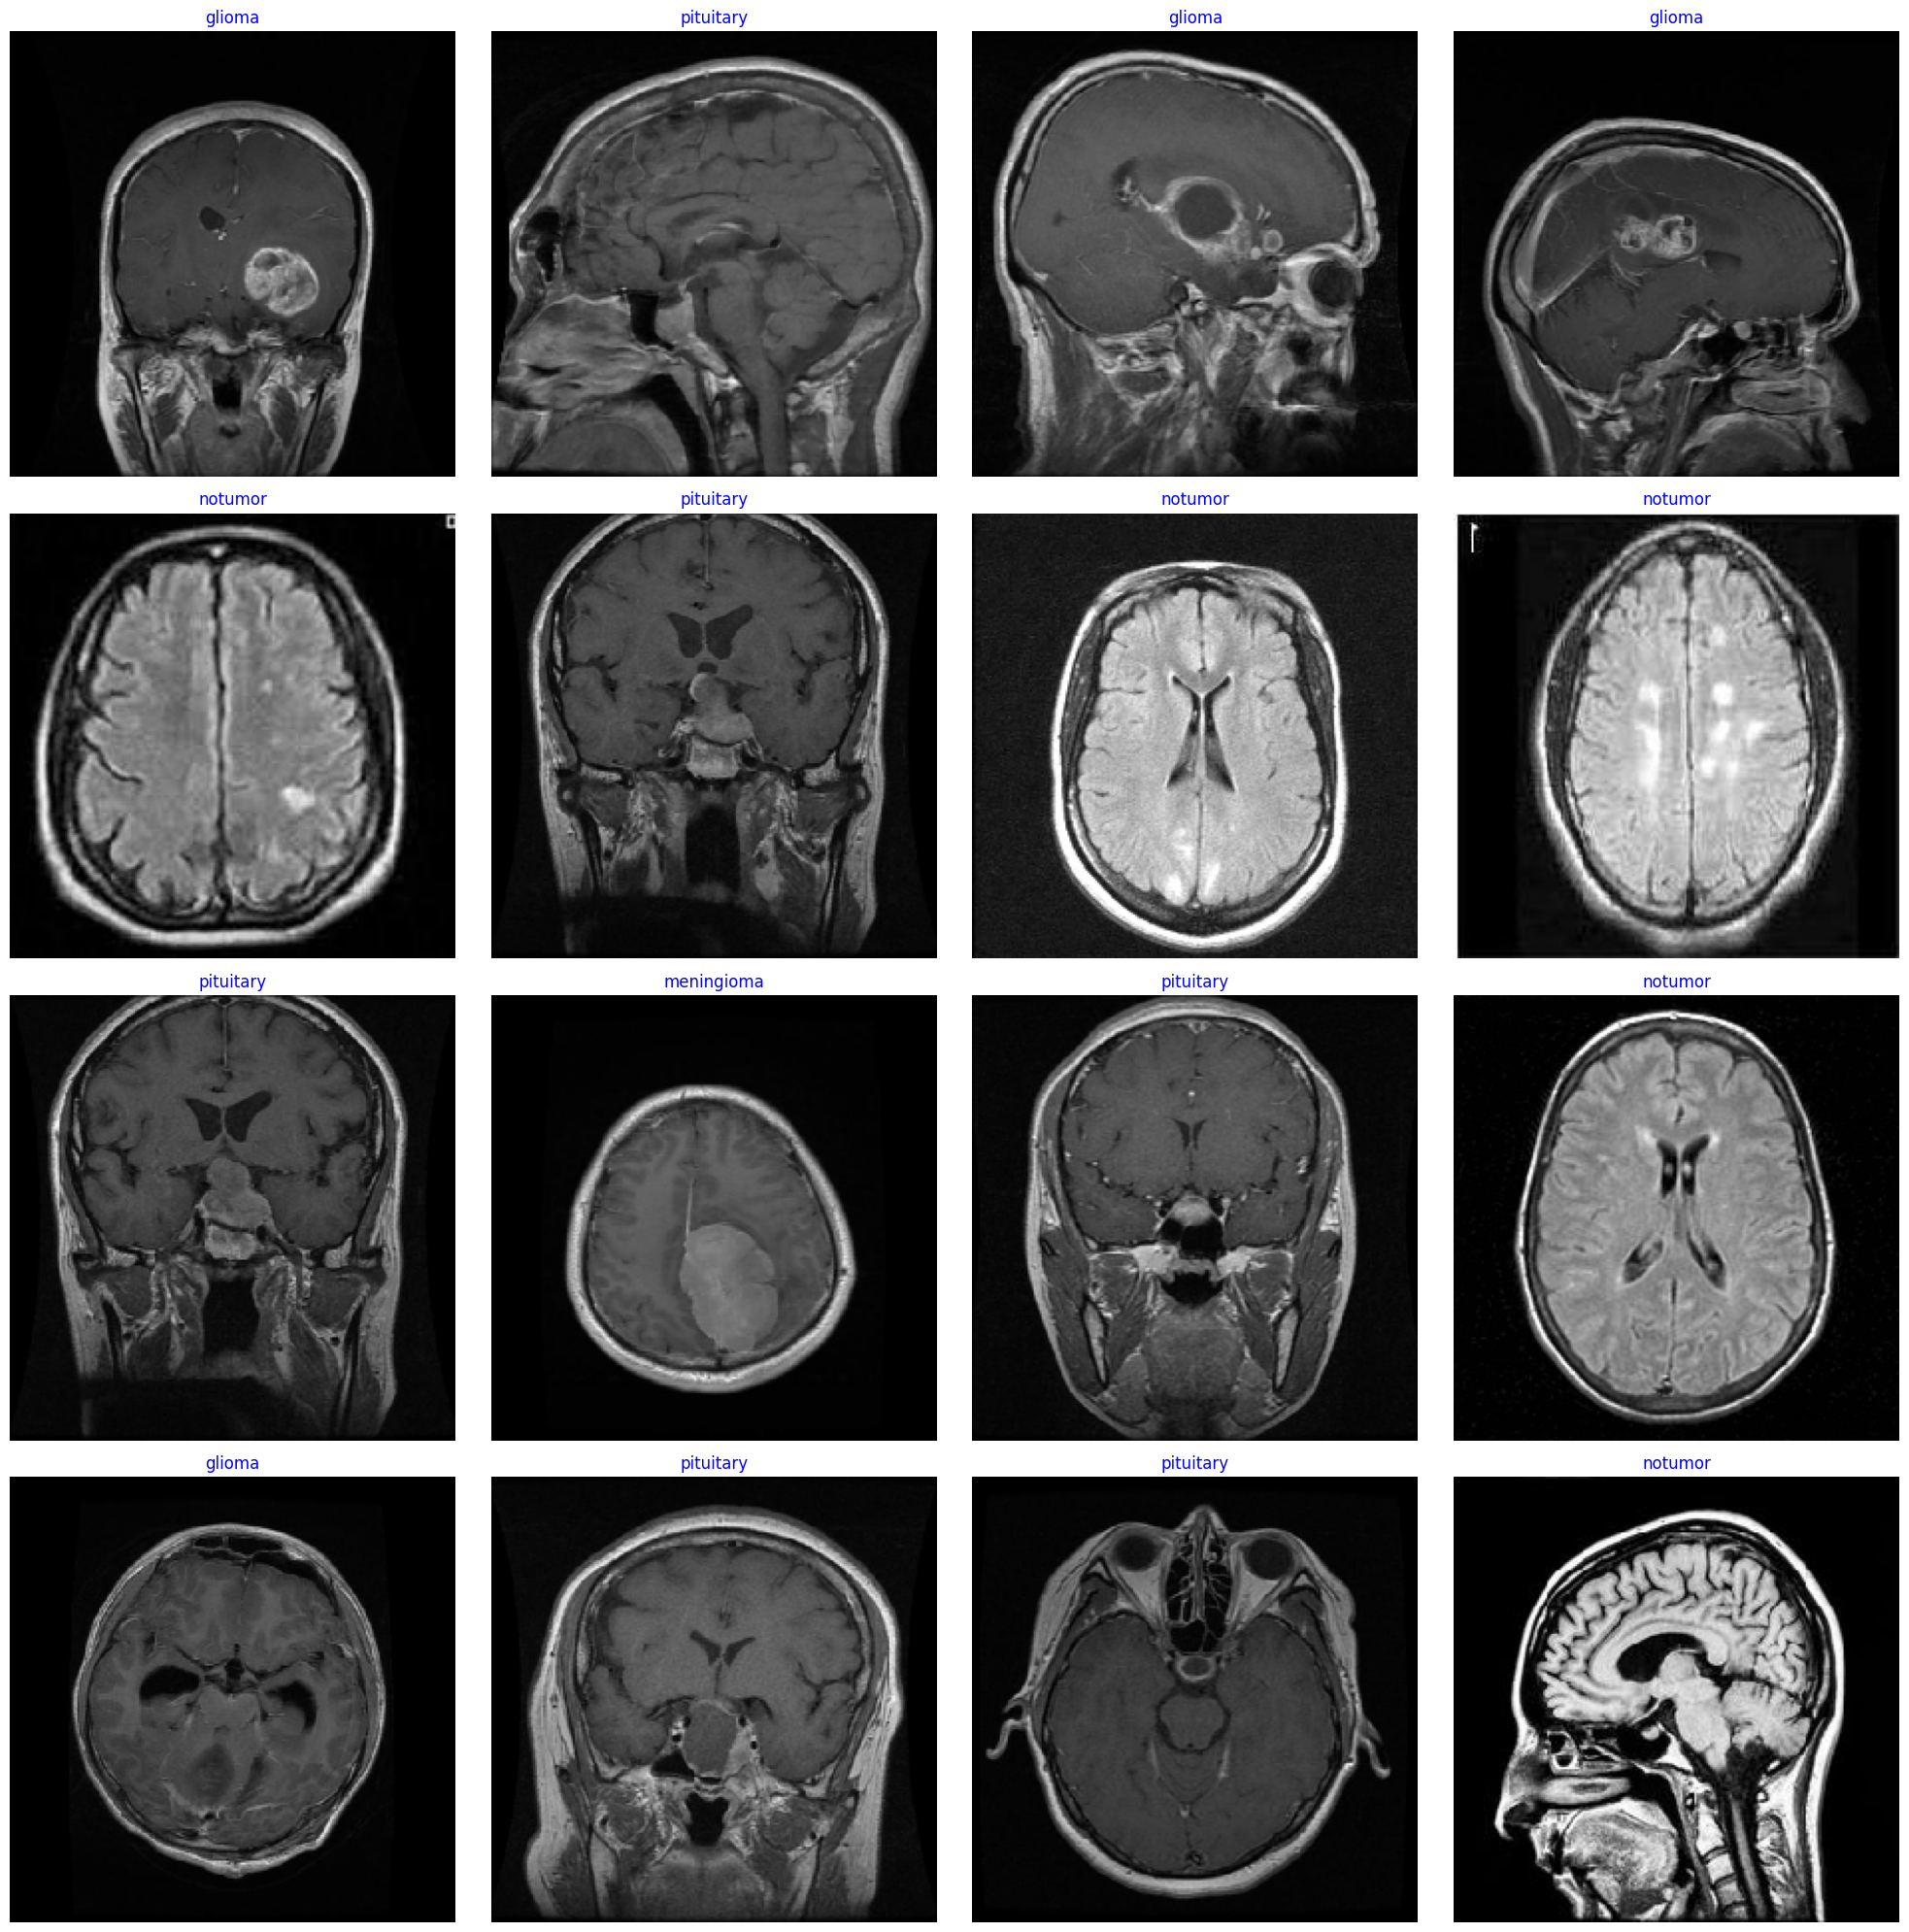

In [13]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", input_shape=img_shape),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(64, activation="relu"),
    Dense(class_count, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

epochs = 10
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 164s 373ms/step - accuracy: 0.4729 - loss: 21.1153 - val_accuracy: 0.6794 - val_loss: 0.7500
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.8042 - loss: 0.4947 - val_accuracy: 0.8244 - val_loss: 0.4622
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.8977 - loss: 0.3097 - val_accuracy: 0.8733 - val_loss: 0.3477
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 266ms/step - accuracy: 0.9168 - loss: 0.2253 - val_accuracy: 0.8809 - val_loss: 0.3777
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.9418 - loss: 0.1592 - val_accuracy: 0.8672 - val_loss: 0.4210
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 266ms/step - accuracy: 0.9416 - loss: 0.1601 - val_accuracy: 0.9374 - val_loss: 0.2012
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 97s 272ms/step - accuracy: 0.9624 - loss: 0.1055 - val_accuracy: 0.9527 - val_loss: 0.1915
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 97s 272ms/step - accuracy: 0.9733 - loss: 0.0730 -

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9762 - loss: 0.1176
Model accuracy on the test set: 96.65%
Model loss on the test set: 0.1832
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.91      0.95       147
  meningioma       0.91      0.95      0.93       153
     notumor       0.99      1.00      0.99       192
   pituitary       0.98      0.99      0.98       164

    accuracy                           0.97       656
   macro avg       0.97      0.96      0.96       656
weighted avg       0.97      0.97      0.97       656



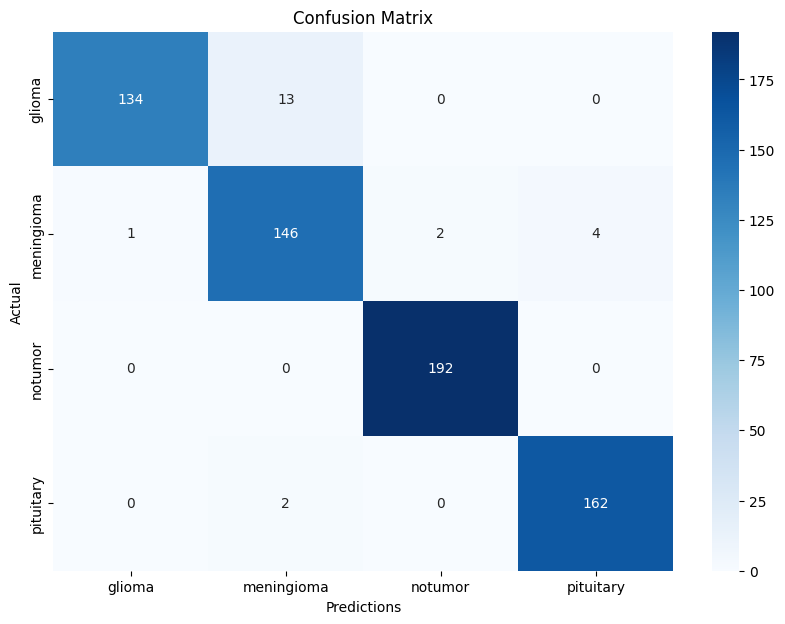

In [17]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)

print(f'Model accuracy on the test set: {test_acc * 100:.2f}%')
print(f'Model loss on the test set: {test_loss:.4f}')

test_gen.reset()
predictions = model.predict(test_gen, verbose=1)

class_names = list(test_gen.class_indices.keys())

predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes

from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()
